## Burndown chart for the whole project on jira using REST API

Docs: https://docs.atlassian.com/jira-software/REST/7.3.1/

In [1]:
import json 
import requests 
import pandas as pd
from pprint import pprint
from datetime import date
import matplotlib.pyplot as plt
from requests.auth import HTTPBasicAuth

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))
%matplotlib notebook

pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
auth = HTTPBasicAuth("jira_account_email_here", "jira_credentials_here")
headers = {"Accept": "application/json"} 

In [4]:
# SPRINT DATA
def get_all_sprints_data(board_id=1):
    url = f"https://bugajski.atlassian.net/rest/agile/1.0/board/{board_id}/sprint" 
    response = requests.request("GET", url, headers=headers, auth=auth) 
    sprints_data = json.loads(response.text)
    return sprints_data

sprints_data = get_all_sprints_data()

# Wartości dla osi x na wykresie
sprints_start_dates = [(sprint["name"], sprint["startDate"]) for sprint in sprints_data["values"]]
sprints_end_dates = [(sprint["name"], sprint["endDate"]) for sprint in sprints_data["values"]]
print(sprints_start_dates)
print(sprints_end_dates)

[('PVD Sprint 0', '2022-03-25T14:49:34.446Z'), ('PVD Sprint 1', '2022-04-01T13:25:34.315Z')]
[('PVD Sprint 0', '2022-04-01T14:49:00.000Z'), ('PVD Sprint 1', '2022-05-06T12:30:00.000Z')]


In [5]:
def get_sprint_issues(sprint_id=2):  # sprint zerowy to 1
    url = f"https://bugajski.atlassian.net/rest/agile/1.0/board/1/sprint/{sprint_id}/issue?maxResults=200" 
    response = requests.request("GET", url, headers=headers, auth=auth) 
    sprint_issues = json.loads(response.text)
    
    return sprint_issues

sprint_issues = get_sprint_issues()
# pprint(sprint_issues)  # dict wszystkich issue w danym sprincie, uwaga spory

In [6]:
def get_sprint_stories(sprint_issues):
    # Inaczej mówiąc wszystkie issue które mają pole story_points 
    # W celu wyjęcia pola "customfield_10026" zawierający wartość story_points danego issue
    stories_issues = [issue for issue in sprint_issues["issues"] if "customfield_10026" in issue["fields"]]  # TODO zamienić na  exists?
    return stories_issues

stories_issues = get_sprint_stories(sprint_issues)

In [7]:
def get_backlog_stories():
    url = f"https://bugajski.atlassian.net/rest/agile/1.0/board/1/backlog?maxResults=200" 
    response = requests.request("GET", url, headers=headers, auth=auth) 
    backlog_issues = json.loads(response.text)
    
    # get only story issues and check if it hasn't been completed becouse jira has moved sprint 0 issues to backlog for some reason
    backlog_issues = [issue for issue in backlog_issues["issues"] if "customfield_10026" in issue["fields"] and not issue["fields"]["resolutiondate"]]
    return backlog_issues

backlog_issues = get_backlog_stories()

In [8]:
def get_summary_df():
    df = pd.DataFrame([], columns=["sprint_id", "story_key", "story_points", "end_date", "story_summary"])
    sprints = get_all_sprints_data()["values"]
    sprint_ids = [sprint["id"] for sprint in sprints]
    for sprint_id in sprint_ids:
        sprint = get_sprint_issues(sprint_id)
        stories = get_sprint_stories(sprint)
        for story in stories:
            story_key = story["key"]
            story_points = story["fields"]["customfield_10026"]
            end_date = story["fields"]["resolutiondate"]
            if end_date:
                end_date = pd.to_datetime(story["fields"]["resolutiondate"]).strftime('%d-%m-%Y')
            story_summary = story["fields"]["summary"]
            df.loc[df.shape[0]] = (sprint_id-1, story_key, story_points, end_date, story_summary)

    backlog_stories = get_backlog_stories()
    for story in backlog_issues:
        story_key = story["key"]
        story_points = story["fields"]["customfield_10026"]
        end_date = story["fields"]["resolutiondate"]
        if end_date:
            end_date = pd.to_datetime(story["fields"]["resolutiondate"]).strftime('%d-%m-%Y')
        story_summary = story["fields"]["summary"]
        df.loc[df.shape[0]] = ("backlog", story_key, story_points, end_date, story_summary)

    return df

df = get_summary_df()
df[1:5]

,sprint_id,story_key,story_points,end_date,story_summary
1,0,PVD-4,None,25-03-2022,Ustawić kolorowanie kart z zadaniami według wy...
2,0,PVD-5,None,25-03-2022,Stworzyć dodatkowe statusy zadania: “Needs Rev...
3,0,PVD-6,None,25-03-2022,Utworzyć dodatkowe kolumny w widoku sprintu: “...
4,0,PVD-7,None,25-03-2022,"Zdefiniować dodatkowy typ zadania (obok story,..."


In [9]:
def get_burndown_df(df, project_start_date):
    burndown_df = pd.DataFrame([], columns = ["total", "date"])
    
    total = df["story_points"].sum()
    df = df.sort_values("end_date").reset_index(drop=True)
    burndown_df.loc[burndown_df.shape[0]] = (total, project_start_date)
    
    for row in range(df.shape[0]):
        if df["story_points"][row] is None:
            continue
        if df["end_date"][row] == None:
            break
        total -= df["story_points"][row]
        burndown_df.loc[burndown_df.shape[0]] = (total, df["end_date"][row])
    
    burndown_df.loc[burndown_df.shape[0]] = (total, date.today().strftime('%d-%m-%Y'))
    burndown_df["date"] = pd.to_datetime(burndown_df["date"], format='%d-%m-%Y').dt.date
    return burndown_df

bdf = get_burndown_df(df, "25-03-2022")
bdf

,total,date
0,214.0,2022-03-25
1,211.0,2022-04-29
2,198.0,2022-04-29
3,193.0,2022-04-29
4,193.0,2022-05-01


<IPython.core.display.Javascript object>


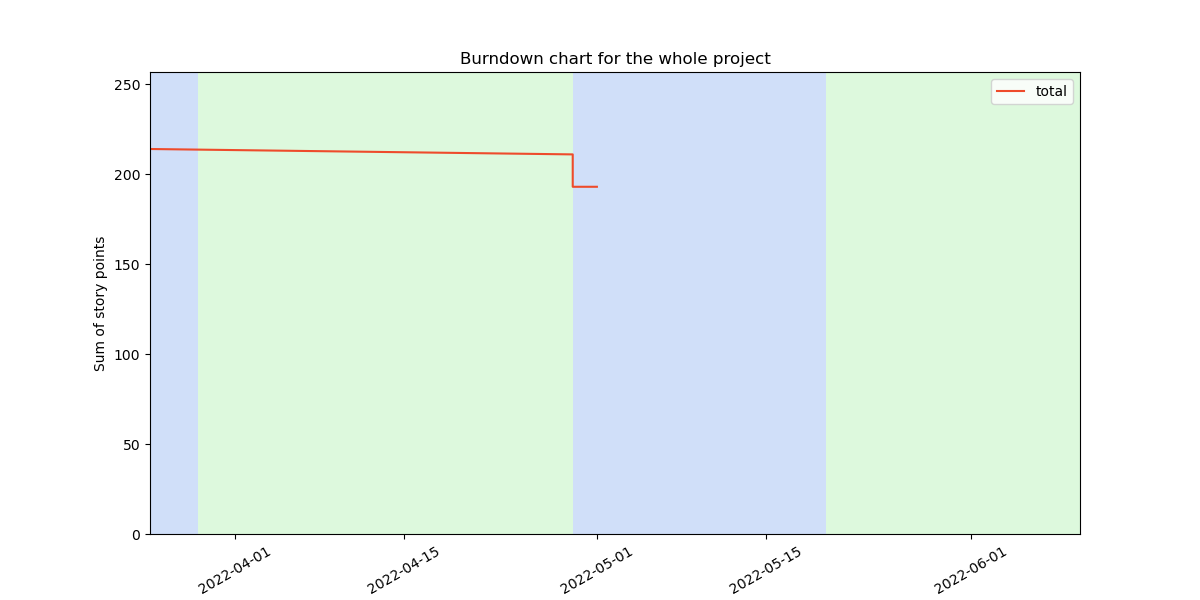

In [11]:
def plot_burndown(burndown_df, project_start_date, project_end_date, sprints_dates):
    project_start_date = pd.to_datetime(project_start_date, format='%d-%m-%Y')
    project_end_date = pd.to_datetime(project_end_date, format='%d-%m-%Y')
    sprints_dates = [pd.to_datetime(date, format='%d-%m-%Y') for date in sprints_dates]

    bdf.plot.line(x="date", y="total", xlabel = "Date", ylabel = "Sum of story points", title="Burndown chart for the whole project", figsize=(12,6),
                  xlim = (project_start_date, project_end_date), ylim = (0, 1.2*max(burndown_df["total"])), rot=30, color = "#EE4B2B")
    
    colormap=["#6495ED", "#90EE90","#6495ED", "#90EE90"]
    for i in range(0, len(sprints_dates)-1, 1):
        plt.axvspan(sprints_dates[i], sprints_dates[i+1], facecolor=colormap[i], alpha=0.3)

        
plot_burndown(bdf, "25-03-2022", "10-06-2022", ["25-03-2022", "29-03-2022", "29-04-2022", "20-05-2022", "10-06-2022"])